# Model developement

## Data & Package import

In [4]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
project_root = os.path.dirname(os.getcwd())

In [ ]:

from dotenv import load_dotenv
load_dotenv()
from utils.gcp import load_data_from_gcs
from google.auth import credentials
from google.cloud import storage


project_root = os.path.dirname(os.getcwd())
service_account = os.path.join(project_root, os.getenv("GCP_SERVICE_ACCOUNT"))
client = storage.Client.from_service_account_json(service_account)

# Load data from GCS
bucket_name = os.getenv("GCP_BUCKET_NAME")
file_name = os.getenv("GCP_DATA_PATH")
data = load_data_from_gcs(bucket_name, file_name, client)

data["tokens"] = data["tokens"].apply(lambda x: eval(x))
data["label"] = data["label"].astype(int)
# Shuffle data and reset_index
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [3]:
data['label'] = data['label'].apply(lambda x: 1 if x == 2 else x)

# 1 - Data Exploration

### EDA

#### Class balance

In [4]:
# Class distribution
class_distribution = data["label"].value_counts(normalize=True)
print(class_distribution)

label
0    0.670398
1    0.329602
Name: proportion, dtype: float64


#### Input Analysis

In [6]:
from tqdm import tqdm
# Explore input length and uniqueness

# Length analysis in prepeparation for padding
data['tokens_length'] = data['tokens'].apply(lambda x: len(x))
mean_length = data['tokens_length'].mean()
quantiles_length = data['tokens_length'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

# Unique tokens per sample
data["unique_tokens"] = data['tokens'].apply(lambda x: len(set(x)))
mean_unique_tokens = data['unique_tokens'].mean()
quantiles_unique_tokens = data['unique_tokens'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])


# Vocabulary analysis
vocab_size = len(set([token for token in data['tokens'] for token in token]))


# Top most frequent tokens
token_count = {}
for row in tqdm(data.tokens, desc="Progress"):
	for token in row :
		if token not in list(token_count.keys()):
			token_count[token] = 1
		else:
			token_count[token] += 1
token_count = dict(sorted(token_count.items(), key=lambda item: item[1], reverse=True))
top_tokens = dict(list(token_count.items())[:20])

Progress: 100%|██████████| 120078/120078 [12:42<00:00, 157.58it/s]


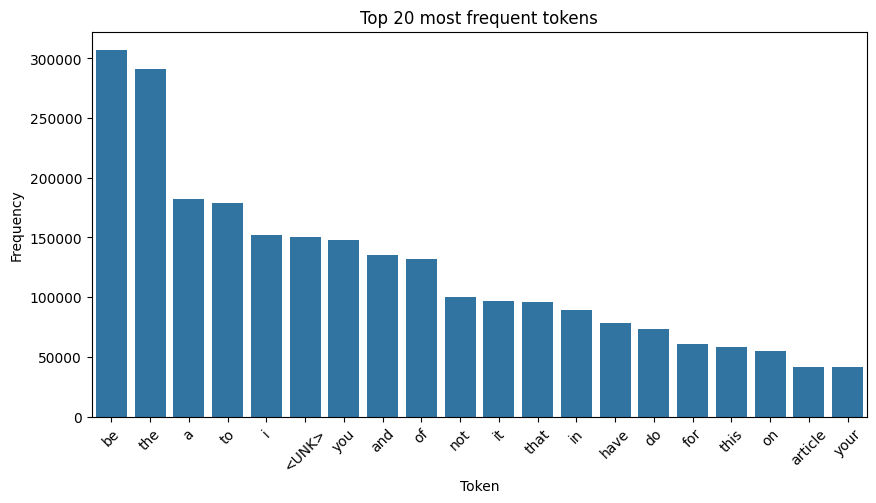

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Data
x = list(top_tokens.keys())
y = list(top_tokens.values())

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.barplot(x=x, y=y, ax=ax)
ax.set_title("Top 20 most frequent tokens")
ax.set_ylabel("Frequency")
ax.set_xlabel("Token")
plt.xticks(rotation=45)
plt.show()

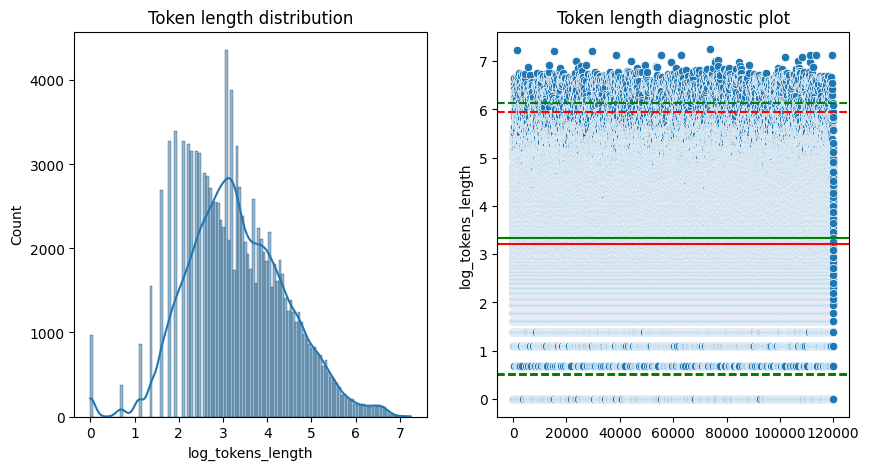

In [8]:
# Token length distribution and outlier detection
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Apply log transformation
data['log_tokens_length'] = data['tokens_length'].apply(lambda x: np.log(x+1))

# Token length distribution
sns.histplot(data['log_tokens_length'], kde=True, ax=ax[0])
ax[0].set_title("Token length distribution")

# Outlier detection
sns.scatterplot(x=list(data.index), y='log_tokens_length', data=data, ax=ax[1])
ax[1].set_title("Token length diagnostic plot")

# Outlier detection
mean = data['log_tokens_length'].mean()
median = data['log_tokens_length'].median()
std = data['log_tokens_length'].std()
mad = np.median(np.abs(data['log_tokens_length'] - median))

upper_bound = median + 2.5*(1.48*mad), mean + 2.5*std
lower_bound = median - 2.5*(1.48*mad), mean - 2.5*std

ax[1].axhline(upper_bound[0], color='r', linestyle='--')
ax[1].axhline(lower_bound[0], color='r', linestyle='--')
ax[1].axhline(upper_bound[1], color='g', linestyle='--')
ax[1].axhline(lower_bound[1], color='g', linestyle='--')
ax[1].axhline(mean, color='g', linestyle='-')
ax[1].axhline(median, color='r', linestyle='-')

plt.show();

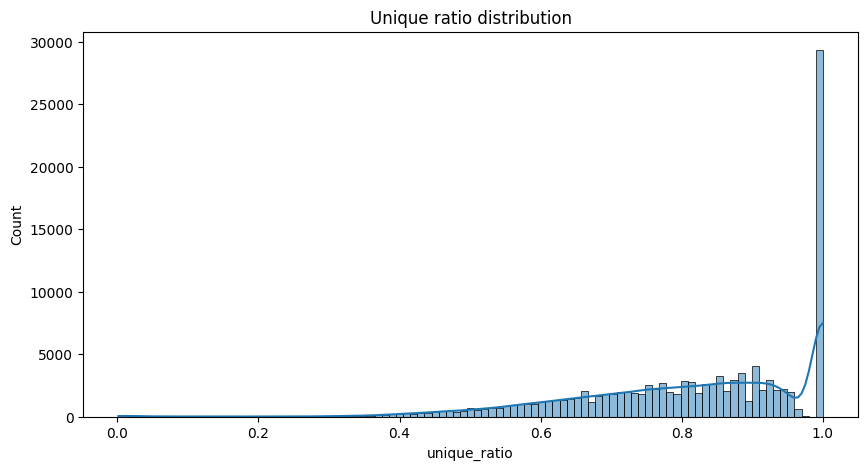

In [9]:
# Explore unique/length of tokens
data["unique_ratio"] = data['unique_tokens'] / data['tokens_length']

# Apply log transformation
epsilon = 1e-6
data['log_unique_ratio'] = data['unique_ratio']


# Unique ratio distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(data['unique_ratio'], kde=True, ax=ax)
plt.title("Unique ratio distribution")
plt.show();

#### Remove outliers

In [10]:
# Remove outliers
data = data[(data['log_tokens_length'] < upper_bound[0]) & (data['log_tokens_length'] > lower_bound[0])]

# Remove empty tokens
data = data[data['tokens_length'] > 0]

# Remove tokens with low unique ratio
data = data[data['unique_ratio'] > 0.2]

In [9]:
# Save data locally
import pickle
path = os.path.join(project_root, "datasets/processed/data.pkl")
with open(path, "wb") as f:
    pickle.dump(data, f)

# Training Setup & Embedding

#### Tokenizer & Embedding

Tokenizer

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Parameters for vectorization
tokens = list(set([token for token in data['tokens'] for token in token]))  
max_tokens = len(tokens) # Vocabulary size
max_length = data.tokens_length.max()    # Sequence length after padding

# Define TextVectorization layer
text_vectorizer = TextVectorization(
    max_tokens=max_tokens,  # Maximum vocab size
    output_mode="int",      # Map tokens to integers
    output_sequence_length=int(max_length), # Ensure padding/truncation
    name="text_vectorizer"  # Name of the layer
)

# Prepare and adapt the vectorizer to the dataset
text_vectorizer.adapt(data["corrected_text"])

NameError: name 'data' is not defined

Embedding

In [ ]:
# Load the pre-trained model
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format(os.path.join(project_root, 'datasets/.originals/Google-News-Vectors-Negative-300.bin'), binary=True)

# Initialize the embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((len(text_vectorizer.get_vocabulary()), embedding_dim))

# Fill the embedding matrix with Word2Vec vectors
for i, word in tqdm(enumerate(text_vectorizer.get_vocabulary()), desc='progression'):
    if i == 0:  # Reserved for padding, indices are already zero-initialized
        continue
    elif word == "[UNK]":  # Default unknown token in TextVectorization
        embedding_matrix[i] = np.random.rand(embedding_dim)
    elif word in word2vec:
        embedding_matrix[i] = word2vec[word]
    else:
        embedding_matrix[i] = np.random.rand(embedding_dim)  # Random vector for OOV tokens

del word2vec

np.save(file=os.path.join(project_root, 'models/embedding_matrix_300.npy'), arr=embedding_matrix)

progression: 28961it [00:02, 14378.03it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'save'

In [14]:
embedding_matrix = np.load(file=os.path.join(project_root, 'models/embedding_matrix_300.npy'))

In [15]:
from tensorflow.keras.layers import Embedding
embedding_dim = 300
embedding_layer = Embedding(
    input_dim=len(text_vectorizer.get_vocabulary()),
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
    name="embedding"
)

#### Model Setup (metrics, input, build_model)

Custom Metrics

In [16]:
import tensorflow as tf
# Define custom metrics
class PrecisionMulticlass(tf.keras.metrics.Metric):
    def __init__(self, name='precision', n_class=2, **kwargs):
        super(PrecisionMulticlass, self).__init__(name=name, **kwargs)
        self.precision = self.add_weight(
            shape=(n_class,),
            name='precision',
            initializer='zeros')
        self.n_class = n_class
        self.true_positives = self.add_weight(name='true_positives', shape=(self.n_class,), initializer='zeros')
        self.false_positives = self.add_weight(name='false_positives', shape=(self.n_class,), initializer='zeros')
        
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.int64)
        y_pred = tf.cast(tf.one_hot(tf.argmax(y_pred, axis=1), self.n_class), tf.int64)
        
        for i in range(self.n_class):
            true_positive = tf.reduce_sum(y_true[:, i] * y_pred[:, i])
            false_positive = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true[:, i], 0), tf.equal(y_pred[:, i], 1)), tf.int64))
            
            index = [[i]]  # Index for the class we are updating
            self.true_positives.assign(tf.tensor_scatter_nd_add(self.true_positives, index, [true_positive]))
            self.false_positives.assign(tf.tensor_scatter_nd_add(self.false_positives, index, [false_positive]))
            
    def result(self):
        precision_per_class = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        return tf.reduce_mean(precision_per_class)
    
    def reset_state(self):
        self.true_positives.assign(tf.zeros(self.n_class))
        self.false_positives.assign(tf.zeros(self.n_class))
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "n_class": self.n_class,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
        

class RecallMulticlass(tf.keras.metrics.Metric):
    def __init__(self, name='recall', n_class=2, **kwargs):
        super(RecallMulticlass, self).__init__(name=name, **kwargs)
        self.recall = self.add_weight(
            shape=(n_class,),
            name='recall',
            initializer='zeros')
        self.n_class = n_class
        self.true_positives = self.add_weight(name='true_positives', shape=(self.n_class,), initializer='zeros')
        self.false_negatives = self.add_weight(name='false_negatives', shape=(self.n_class,), initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.int64)
        y_pred = tf.cast(tf.one_hot(tf.argmax(y_pred, axis=1), self.n_class), tf.int64)
        
        for i in range(self.n_class):
            true_positive = tf.reduce_sum(y_true[:, i] * y_pred[:, i])
            false_negative = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true[:, i], 1), tf.equal(y_pred[:, i], 0)), tf.int64))
            
            index = [[i]]  # Index for the class we are updating
            self.true_positives.assign(tf.tensor_scatter_nd_add(self.true_positives, index, [true_positive]))
            self.false_negatives.assign(tf.tensor_scatter_nd_add(self.false_negatives, index, [false_negative]))
            
    def result(self):
        recall_per_class = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return tf.reduce_mean(recall_per_class)
    
    def reset_state(self):
        self.true_positives.assign(tf.zeros(self.n_class))
        self.false_negatives.assign(tf.zeros(self.n_class))
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "n_class": self.n_class,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
        
        
        
class F1ScoreMulticlass(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', n_class=2, **kwargs):
        super(F1ScoreMulticlass, self).__init__(name=name, **kwargs)
        self.n_class = n_class
        self.precision = PrecisionMulticlass(n_class=n_class)
        self.recall = RecallMulticlass(n_class=n_class)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "n_class": self.n_class,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
        
        

Custom Loss

In [10]:
# Define custom weighted loss
class_distribution = data['label'].value_counts(normalize=True)
weights = (1/class_distribution) # Weight
weights = weights / weights.sum() # Normalize

# Define custom loss
class WeightedCategoricalCrossEntropy(tf.keras.losses.Loss):
    def __init__(self, weights, name='weighted_categorical_crossentropy', **kwargs):
        super(WeightedCategoricalCrossEntropy, self).__init__()
        self.weights = tf.cast(weights, tf.float32)
        
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        # Clip y_pred to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        weighted_losses = -self.weights * y_true * tf.math.log(y_pred)
        return tf.reduce_mean(tf.reduce_sum(weighted_losses, axis=1))
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "weights": self.weights,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

NameError: name 'data' is not defined

Callbacks

In [9]:
import os
import tensorflow as tf

# Early stopping

def early_stopping():
    return tf.keras.callbacks.EarlyStopping(
        monitor='recall',     
        patience=10,             
        mode='max',            
        min_delta=0.001,        
        restore_best_weights=True
    )

# TensorBoard
def tensorboard(log_dir:str = os.path.join(project_root, "logs", "fit")):
    return tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ModelCheckpoint
def model_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(project_root, "models", f"{model_name}"),
        monitor='val_recall',
        save_best_only=True,
        save_weights_only=False,
        save_format='tf',
        mode='max',
        verbose=1
    )

Build Dataset

In [32]:
data.columns

Index(['source', 'text', 'label', 'id', 'corrected_text', 'tokens',
       'tokens_length', 'unique_tokens', 'log_tokens_length', 'unique_ratio',
       'log_unique_ratio'],
      dtype='object')

In [8]:
def build_dataset(data: pd.DataFrame, batch_size:int = 512):
    from tensorflow.keras.utils import to_categorical
    
    # Prepare dataset
    X = data["corrected_text"]
    y = data["label"]
    y = to_categorical(y, num_classes=2)

    # Split data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create tf.data.Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


    return train_dataset.batch(batch_size), test_dataset.batch(batch_size), X_test.index #, X_train, X_test, y_train, y_test

In [ ]:
import os
import pickle

# Save the TextVectorization layer configuration and weights
text_vectorizer_config = text_vectorizer.get_config()
text_vectorizer_weights = text_vectorizer.get_weights()

with open(os.path.join(project_root, 'models', 'text_vectorizer', 'config.pkl'), 'wb') as f:
    pickle.dump(text_vectorizer_config, f)

with open(os.path.join(project_root, 'models', 'text_vectorizer', 'weights.pkl'), 'wb') as f:
    pickle.dump(text_vectorizer_weights, f)

In [54]:
training_data.save(os.path.join(project_root, 'datasets', 'training', 'training_data_2labels'))
testing_data.save(os.path.join(project_root, 'datasets', 'training', 'testing_data_2labels'))

Train / Test class balance check

In [147]:
#train_dataset, test_dataset, X_train, X_test, y_train, y_test = build_dataset(data)

# Inspect class balance on training set and test set
#train_labels = y_train.argmax(axis=1)
#test_labels = y_test.argmax(axis=1)
#
## Train balance analysis
#class_count = np.unique(train_labels, return_counts=True)[1]
#total = class_count.sum()
#train_class_distribution = class_count / total
#print(f"Train class distribution: {train_class_distribution}")
#
## Test balance analysis
#class_count = np.unique(test_labels, return_counts=True)[1]
#total = class_count.sum()
#test_class_distribution = class_count / total
#print(f"Test class distribution: {test_class_distribution}")
#
## Total class distrib
#print(f"Total class distribution : {list(class_distribution)}")

Model

In [20]:
def build_model(layers: list, loss: tf.keras.losses.Loss, metrics: list, model_name: str):
    
    tf.random.set_seed(42)
    
    # Define model
    # Input Layer
    inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='features')
    x = text_vectorizer(inputs)
    x = embedding_layer(x)
    
    
    # Hidden Layers
    for layer in layers:
        x = layer(x)
        
    # Output Layer
    outputs = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)
    
    # Model
    model = tf.keras.Model(inputs, outputs, name=model_name)
    
    # Compile
    model.compile(
        loss=loss,
        optimizer=tf.keras.optimizers.legacy.Adam(),
        metrics=metrics,
    )
    
    model.summary()
    
    return model
    

In [7]:
def train_model(model, training_data, testing_data, epochs:int = 100, callbacks:list = None):
    history = model.fit(training_data,
        validation_data=testing_data,
        epochs=epochs,
        callbacks=callbacks
    )
    
    return history

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report

def plot_classification_report(model, testing_data):
    """
    This function takes a model and testing dataset as input, evaluates the model on the test set, 
    and generates a classification report with precision, recall, and F1 scores per class.
    
    Parameters:
    - model: A trained Keras model
    - testing_data: A TensorFlow dataset (or a tf.data.Dataset) that contains features and labels for evaluation.
    
    Returns:
    - A bar plot with precision, recall, and F1 scores per label.
    """

    # Evaluate the model on the test set
    metrics = model.evaluate(testing_data)
    # Print overall results
    print("Overall results")
    for metric, value in zip(model.metrics_names, metrics):
        print(f"{metric}: {value}")

    # Get true labels and predictions
    y_pred = model.predict(testing_data)
    y_pred = y_pred.argmax(axis=1)  # Convert predictions to label indices (class labels)

    # Extract all labels from the testing_data
    def get_all_labels(dataset):
        all_labels = []
        for batch in dataset.as_numpy_iterator():
            labels = batch[1]  # Assuming '1' corresponds to the labels in your dataset
            all_labels.append(labels)
        return np.concatenate(all_labels, axis=0)

    # Get true labels as a single NumPy array
    true_labels_one_hot = get_all_labels(testing_data)
    true_labels = true_labels_one_hot.argmax(axis=1)

    # Generate classification report
    report = classification_report(true_labels, y_pred, target_names=["Neutral", "Toxic"], output_dict=True)

    # Convert the classification report dictionary into a pandas DataFrame
    report_df = pd.DataFrame(report).transpose()

    # Plotting grouped bars for precision, recall, and F1-score
    ax = report_df[['precision', 'recall', 'f1-score']].plot(kind='barh', figsize=(10, 6))
    
    # Set plot title and labels
    ax.set_title('Classification Report Metrics per Label')
    ax.set_xlabel('Scores')
    ax.set_ylabel('Labels')
    ax.legend(title="Metrics")
    
    # Display the plot
    plt.tight_layout()
    plt.show()

    return ax, metrics  # Return axis object for further manipulation if needed



def plot_metrics_with_seaborn(history):

    # Extract metrics from history
    metrics = [key for key in history.history.keys() if 'val_' not in key]
    epochs = range(1, len(history.history[metrics[0]]) + 1)
    

    for metric in metrics:
        plt.figure(figsize=(6, 3))
        
        # Plot training metric
        sns.lineplot(x=epochs, y=history.history[metric], label=f'Training {metric.capitalize()}', marker='o')
        
        # Plot validation metric if available
        if f'val_{metric}' in history.history:
            sns.lineplot(x=epochs, y=history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}', marker='o')
        
        # Formatting
        plt.title(f'{metric.capitalize()} Over Epochs', fontsize=16)
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel(metric.capitalize(), fontsize=14)
        plt.legend(loc='best', fontsize=12)
        plt.grid(True)
        plt.xticks(epochs)  # Show each epoch number on x-axis
        plt.tight_layout()  # Adjust layout for better fit
        plt.show()

# Training

In [23]:
import tensorflow as tf

# Check if GPUs are available
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Available GPUs:", gpus)


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Baseline Model

Build model

In [198]:
# Data
training_data, testing_data = build_dataset(data)

# Metrics
metrics = [
    PrecisionMulticlass(n_class=2),
    RecallMulticlass(n_class=2),
    F1ScoreMulticlass(n_class=2),
]

# Loss
loss = WeightedCategoricalCrossEntropy(weights)

# Callbacks
callbacks = [
    early_stopping(),
    #tensorboard(),
    model_checkpoint("baseline_model")
]

# Layers
layers = [
    tf.keras.layers.LSTM(64, return_sequences=False, name='lstm'),
    tf.keras.layers.Dense(64, activation='relu', name='dense_1'),
    tf.keras.layers.Dense(32, activation='relu', name='dense_2')
]

# Model
model = build_model(layers=layers, loss=loss, metrics=metrics, 
                    model_name="baseline_model")

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 features (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorizer (TextVecto  (None, 376)               0         
 rization)                                                       
                                                                 
 embedding (Embedding)       (None, 376, 300)          8688300   
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                    

Training

In [169]:
baseline_model_history = train_model(model, training_data, testing_data, epochs=100, callbacks=callbacks)

Epoch 1/100
183/183 [==============================] - ETA: 0s - loss: 0.2292 - precision: 0.3328 - recall: 0.3323 - f1_score: 0.3326
Epoch 1: recall improved from -inf to 0.33234, saving model to /Users/theopinto--dalle/code/arewetoxic/models/baseline_model
INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/baseline_model/assets


INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/baseline_model/assets


183/183 [==============================] - 55s 270ms/step - loss: 0.2292 - precision: 0.3328 - recall: 0.3323 - f1_score: 0.3326 - val_loss: 0.2301 - val_precision: 0.3739 - val_recall: 0.3351 - val_f1_score: 0.3534
Epoch 2/100
183/183 [==============================] - ETA: 0s - loss: 0.2293 - precision: 0.3362 - recall: 0.3322 - f1_score: 0.3342
Epoch 2: recall did not improve from 0.33234
183/183 [==============================] - 41s 224ms/step - loss: 0.2293 - precision: 0.3362 - recall: 0.3322 - f1_score: 0.3342 - val_loss: 0.2301 - val_precision: 0.3759 - val_recall: 0.3352 - val_f1_score: 0.3544
Epoch 3/100
183/183 [==============================] - ETA: 0s - loss: 0.2290 - precision: 0.3359 - recall: 0.3355 - f1_score: 0.3357
Epoch 3: recall improved from 0.33234 to 0.33546, saving model to /Users/theopinto--dalle/code/arewetoxic/models/baseline_model
INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/baseline_model/assets


INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/baseline_model/assets


183/183 [==============================] - 41s 226ms/step - loss: 0.2290 - precision: 0.3359 - recall: 0.3355 - f1_score: 0.3357 - val_loss: 0.2300 - val_precision: 0.2213 - val_recall: 0.3333 - val_f1_score: 0.2660
Epoch 4/100
183/183 [==============================] - ETA: 0s - loss: 0.2292 - precision: 0.3359 - recall: 0.3374 - f1_score: 0.3367
Epoch 4: recall improved from 0.33546 to 0.33743, saving model to /Users/theopinto--dalle/code/arewetoxic/models/baseline_model
INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/baseline_model/assets


INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/baseline_model/assets


183/183 [==============================] - 41s 225ms/step - loss: 0.2292 - precision: 0.3359 - recall: 0.3374 - f1_score: 0.3367 - val_loss: 0.2301 - val_precision: 0.2213 - val_recall: 0.3333 - val_f1_score: 0.2660
Epoch 5/100
183/183 [==============================] - ETA: 0s - loss: 0.2292 - precision: 0.3415 - recall: 0.3370 - f1_score: 0.3392
Epoch 5: recall did not improve from 0.33743
183/183 [==============================] - 44s 240ms/step - loss: 0.2292 - precision: 0.3415 - recall: 0.3370 - f1_score: 0.3392 - val_loss: 0.2297 - val_precision: 0.4029 - val_recall: 0.3433 - val_f1_score: 0.3707
Epoch 6/100
183/183 [==============================] - ETA: 0s - loss: 0.2290 - precision: 0.3344 - recall: 0.3341 - f1_score: 0.3342
Epoch 6: recall did not improve from 0.33743
183/183 [==============================] - 35s 191ms/step - loss: 0.2290 - precision: 0.3344 - recall: 0.3341 - f1_score: 0.3342 - val_loss: 0.2301 - val_precision: 0.2213 - val_recall: 0.3333 - val_f1_score: 0

INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/baseline_model/assets


183/183 [==============================] - 40s 216ms/step - loss: 0.2294 - precision: 0.3388 - recall: 0.3393 - f1_score: 0.3390 - val_loss: 0.2301 - val_precision: 0.3470 - val_recall: 0.3339 - val_f1_score: 0.3404
Epoch 9/100
183/183 [==============================] - ETA: 0s - loss: 0.2291 - precision: 0.3330 - recall: 0.3328 - f1_score: 0.3329
Epoch 9: recall did not improve from 0.33927
183/183 [==============================] - 37s 200ms/step - loss: 0.2291 - precision: 0.3330 - recall: 0.3328 - f1_score: 0.3329 - val_loss: 0.2301 - val_precision: 0.2212 - val_recall: 0.3331 - val_f1_score: 0.2659
Epoch 10/100
183/183 [==============================] - ETA: 0s - loss: 0.2290 - precision: 0.3346 - recall: 0.3347 - f1_score: 0.3347
Epoch 10: recall did not improve from 0.33927
183/183 [==============================] - 35s 192ms/step - loss: 0.2290 - precision: 0.3346 - recall: 0.3347 - f1_score: 0.3347 - val_loss: 0.2300 - val_precision: 0.2213 - val_recall: 0.3333 - val_f1_score:

Model Evaluation

46/46 [==============================] - 4s 80ms/step - loss: 0.2301 - precision: 0.3739 - recall: 0.3351 - f1_score: 0.3534
Overall results
loss: 0.23012278974056244
precision: 0.37388724088668823
recall: 0.33506104350090027
f1_score: 0.35341089963912964
46/46 [==============================] - 3s 58ms/step


/Users/theopinto--dalle/code/arewetoxic/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/theopinto--dalle/code/arewetoxic/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/theopinto--dalle/code/arewetoxic/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

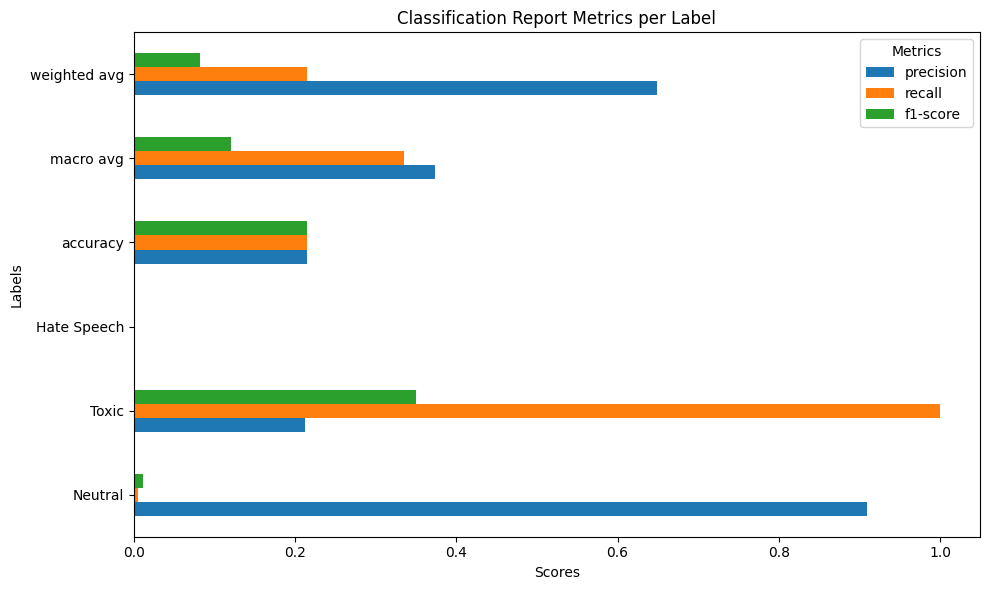

(<Axes: title={'center': 'Classification Report Metrics per Label'}, xlabel='Scores', ylabel='Labels'>,
 [0.23012278974056244,
  0.37388724088668823,
  0.33506104350090027,
  0.35341089963912964])

In [170]:
plot_classification_report(model, testing_data)

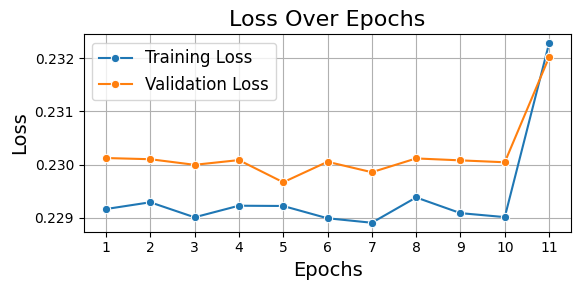

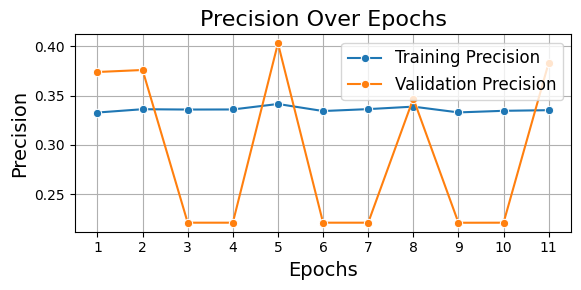

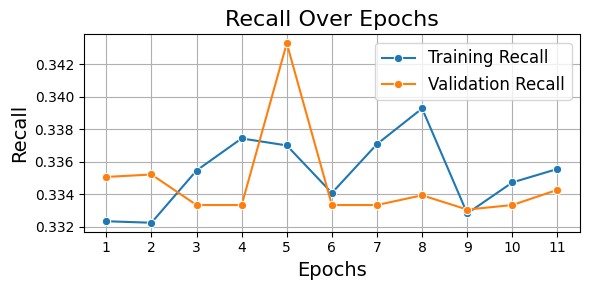

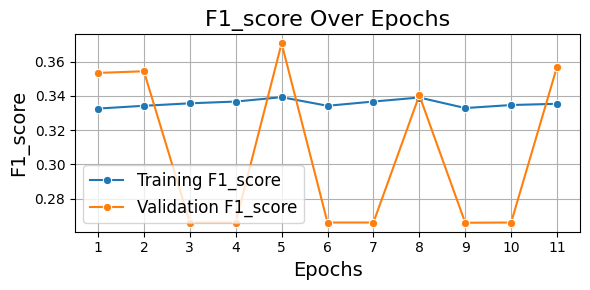

In [171]:
plot_metrics_with_seaborn(baseline_model_history)

## Bidirectionnal LSTM

In [ ]:
# Data
training_data, testing_data = build_dataset(data)

# Metrics
metrics = [
    PrecisionMulticlass(n_class=2),
    RecallMulticlass(n_class=2),
    F1ScoreMulticlass(n_class=2),
]

# Loss
loss = WeightedCategoricalCrossEntropy(weights)

# Callbacks
callbacks = [
    early_stopping(),
    #tensorboard(),
    model_checkpoint("bi_lstm")
]

# Layers
layers = [
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation="tanh",return_sequences=True, name='bi_lstm')),
    tf.keras.layers.Dropout(0.2, name='dropout'),
    tf.keras.layers.LSTM(64, activation='tanh', name='lstm', return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu', name='dense_1'),
    tf.keras.layers.Dropout(0.2, name='dropout_2'),
    tf.keras.layers.Dense(64, activation='relu', name='dense_2'),
    tf.keras.layers.Dense(16, activation='relu', name='dense_3')
]

# Model
bi_lstm_model = build_model(layers=layers, loss=loss, metrics=metrics, 
                    model_name="bi_lstm_2")

Model: "bi_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 features (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorizer (TextVecto  (None, 376)               0         
 rization)                                                       
                                                                 
 embedding (Embedding)       (None, 376, 300)          8688300   
                                                                 
 bidirectional_13 (Bidirect  (None, 376, 128)          186880    
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 376, 128)          0         
                                                                 
 lstm (LSTM)                 (None, 64)                4940

In [ ]:
bi_lstm_model_history = train_model(bi_lstm_model, training_data, testing_data, epochs=100, callbacks=callbacks)

Epoch 1/100
183/183 [==============================] - ETA: 0s - loss: 0.2326 - precision: 0.3320 - recall: 0.3320 - f1_score: 0.3320
Epoch 1: val_recall improved from -inf to 0.33406, saving model to /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm
INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


183/183 [==============================] - 217s 1s/step - loss: 0.2326 - precision: 0.3320 - recall: 0.3320 - f1_score: 0.3320 - val_loss: 0.2301 - val_precision: 0.3790 - val_recall: 0.3341 - val_f1_score: 0.3551
Epoch 2/100
183/183 [==============================] - ETA: 0s - loss: 0.2419 - precision: 0.3323 - recall: 0.3316 - f1_score: 0.3320
Epoch 2: val_recall did not improve from 0.33406
183/183 [==============================] - 256s 1s/step - loss: 0.2419 - precision: 0.3323 - recall: 0.3316 - f1_score: 0.3320 - val_loss: 0.2319 - val_precision: 0.2213 - val_recall: 0.3333 - val_f1_score: 0.2660
Epoch 3/100
183/183 [==============================] - ETA: 0s - loss: 0.2340 - precision: 0.3343 - recall: 0.3338 - f1_score: 0.3340
Epoch 3: val_recall did not improve from 0.33406
183/183 [==============================] - 272s 1s/step - loss: 0.2340 - precision: 0.3343 - recall: 0.3338 - f1_score: 0.3340 - val_loss: 0.2311 - val_precision: 0.0414 - val_recall: 0.3333 - val_f1_score:

INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


183/183 [==============================] - 131s 715ms/step - loss: 0.2291 - precision: 0.3440 - recall: 0.3451 - f1_score: 0.3446 - val_loss: 0.2211 - val_precision: 0.3434 - val_recall: 0.4557 - val_f1_score: 0.3916
Epoch 14/100
183/183 [==============================] - ETA: 0s - loss: 0.1888 - precision: 0.5067 - recall: 0.5286 - f1_score: 0.5174
Epoch 14: val_recall improved from 0.45574 to 0.55567, saving model to /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm
INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


183/183 [==============================] - 122s 660ms/step - loss: 0.1888 - precision: 0.5067 - recall: 0.5286 - f1_score: 0.5174 - val_loss: 0.1785 - val_precision: 0.4011 - val_recall: 0.5557 - val_f1_score: 0.4659
Epoch 15/100
183/183 [==============================] - ETA: 0s - loss: 0.1608 - precision: 0.5714 - recall: 0.5879 - f1_score: 0.5795
Epoch 15: val_recall improved from 0.55567 to 0.59363, saving model to /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm
INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


183/183 [==============================] - 127s 685ms/step - loss: 0.1608 - precision: 0.5714 - recall: 0.5879 - f1_score: 0.5795 - val_loss: 0.1548 - val_precision: 0.4139 - val_recall: 0.5936 - val_f1_score: 0.4878
Epoch 16/100
183/183 [==============================] - ETA: 0s - loss: 0.1517 - precision: 0.5898 - recall: 0.6021 - f1_score: 0.5959
Epoch 16: val_recall improved from 0.59363 to 0.60019, saving model to /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm
INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


183/183 [==============================] - 151s 823ms/step - loss: 0.1517 - precision: 0.5898 - recall: 0.6021 - f1_score: 0.5959 - val_loss: 0.1488 - val_precision: 0.4174 - val_recall: 0.6002 - val_f1_score: 0.4923
Epoch 17/100
183/183 [==============================] - ETA: 0s - loss: 0.1830 - precision: 0.4853 - recall: 0.5014 - f1_score: 0.4932
Epoch 17: val_recall did not improve from 0.60019
183/183 [==============================] - 107s 575ms/step - loss: 0.1830 - precision: 0.4853 - recall: 0.5014 - f1_score: 0.4932 - val_loss: 0.2303 - val_precision: 0.0414 - val_recall: 0.3333 - val_f1_score: 0.0737
Epoch 18/100
183/183 [==============================] - ETA: 0s - loss: 0.2412 - precision: 0.3593 - recall: 0.3606 - f1_score: 0.3600
Epoch 18: val_recall did not improve from 0.60019
183/183 [==============================] - 105s 572ms/step - loss: 0.2412 - precision: 0.3593 - recall: 0.3606 - f1_score: 0.3600 - val_loss: 0.2356 - val_precision: 0.2213 - val_recall: 0.3333 - 

46/46 [==============================] - 17s 284ms/step - loss: 0.1488 - precision: 0.4174 - recall: 0.6002 - f1_score: 0.4923
Overall results
loss: 0.1487901210784912
precision: 0.41735756397247314
recall: 0.6001896262168884
f1_score: 0.49234798550605774
46/46 [==============================] - 13s 210ms/step


/Users/theopinto--dalle/code/arewetoxic/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/theopinto--dalle/code/arewetoxic/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/theopinto--dalle/code/arewetoxic/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

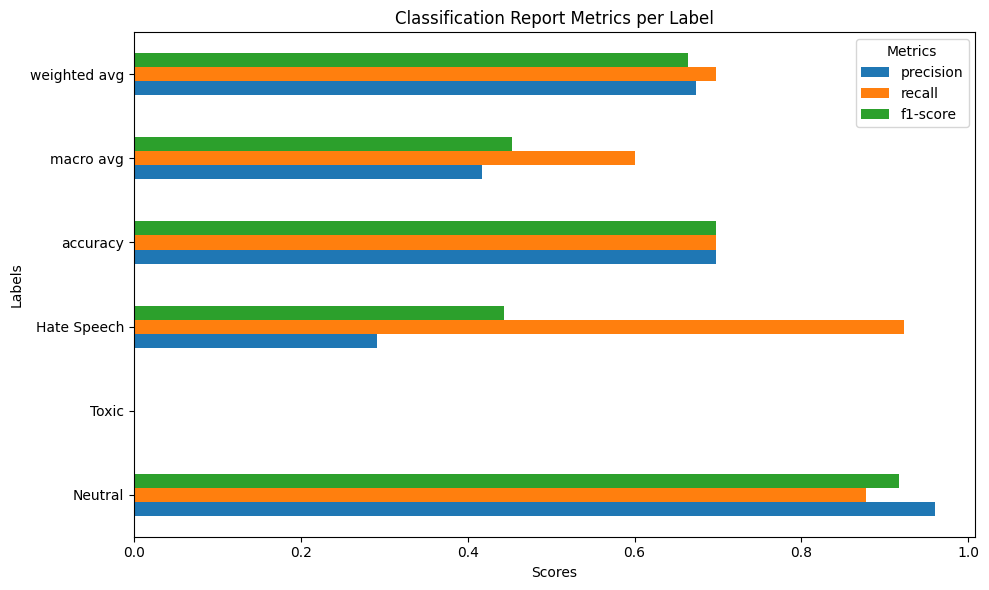

(<Axes: title={'center': 'Classification Report Metrics per Label'}, xlabel='Scores', ylabel='Labels'>,
 [0.1487901210784912,
  0.41735756397247314,
  0.6001896262168884,
  0.49234798550605774])

In [183]:
plot_classification_report(bi_lstm_model, testing_data)

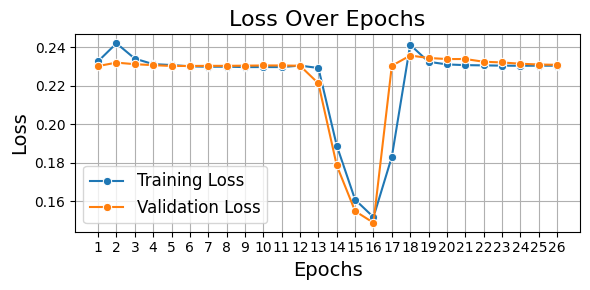

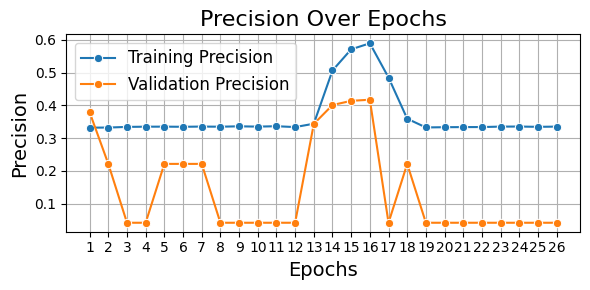

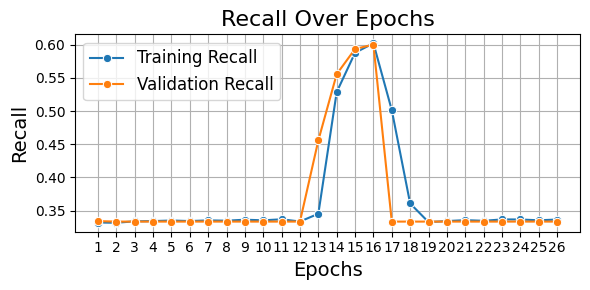

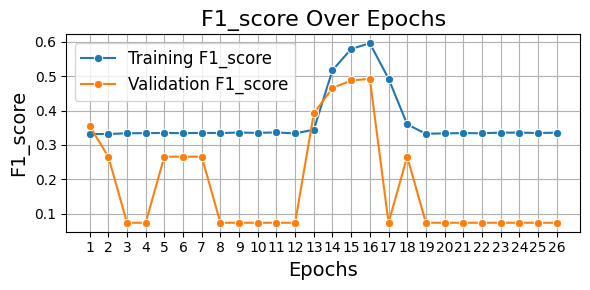

In [184]:
plot_metrics_with_seaborn(bi_lstm_model_history)

## GRU model

In [17]:
data = pd.read_pickle(os.path.join(project_root, "datasets/processed/data.pkl"))
data['label'] = data['label'].apply(lambda x: 1 if x == 2 else x)
training_data, testing_data, test_indices = build_dataset(data)


In [ ]:
# Data
#training_data, testing_data = build_dataset(data)

# Metrics
metrics = [
    PrecisionMulticlass(n_class=2),
    RecallMulticlass(n_class=2),
    F1ScoreMulticlass(n_class=2),
]

# Loss
loss = WeightedCategoricalCrossEntropy(weights)

# Callbacks
callbacks = [
    early_stopping(),
    #tensorboard(),
    model_checkpoint("bi_lstm")
]

# Layers
layers = [
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation="tanh",return_sequences=True, name='bi_GRU')),
    tf.keras.layers.Dropout(0.2, name='dropout'),
    tf.keras.layers.GRU(128, activation='tanh', name='GRU'),
    tf.keras.layers.Dropout(0.2, name='dropout_1'),
    tf.keras.layers.Dense(64, activation='relu', name='dense_1'),
    tf.keras.layers.Dropout(0.2, name='dropout_2'),
    tf.keras.layers.Dense(16, activation='relu', name='dense_2')
]

# Model
bi_gru_model = build_model(layers=layers, loss=loss, metrics=metrics, 
                    model_name="bi_gru")

Model: "bi_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 features (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorizer (TextVecto  (None, 376)               0         
 rization)                                                       
                                                                 
 embedding (Embedding)       (None, 376, 300)          8688300   
                                                                 
 bidirectional_16 (Bidirect  (None, 376, 128)          140544    
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 376, 128)          0         
                                                                 
 GRU (GRU)                   (None, 128)               99072

In [ ]:
bi_gru_model_history = train_model(bi_gru_model, training_data, testing_data, epochs=100, callbacks=callbacks)

Epoch 1/100
183/183 [==============================] - ETA: 0s - loss: 0.3085 - precision: 0.5017 - recall: 0.5019 - f1_score: 0.5018
Epoch 1: val_recall improved from -inf to 0.50097, saving model to /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm
INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


183/183 [==============================] - 539s 3s/step - loss: 0.3085 - precision: 0.5017 - recall: 0.5019 - f1_score: 0.5018 - val_loss: 0.3089 - val_precision: 0.6531 - val_recall: 0.5010 - val_f1_score: 0.5670
Epoch 2/100
183/183 [==============================] - ETA: 0s - loss: 0.3678 - precision: 0.5023 - recall: 0.5025 - f1_score: 0.5024
Epoch 2: val_recall did not improve from 0.50097
183/183 [==============================] - 531s 3s/step - loss: 0.3678 - precision: 0.5023 - recall: 0.5025 - f1_score: 0.5024 - val_loss: 0.3234 - val_precision: 0.3319 - val_recall: 0.5000 - val_f1_score: 0.3990
Epoch 3/100
183/183 [==============================] - ETA: 0s - loss: 0.2345 - precision: 0.7486 - recall: 0.7687 - f1_score: 0.7585
Epoch 3: val_recall improved from 0.50097 to 0.91028, saving model to /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm
INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


183/183 [==============================] - 582s 3s/step - loss: 0.2345 - precision: 0.7486 - recall: 0.7687 - f1_score: 0.7585 - val_loss: 0.1052 - val_precision: 0.8976 - val_recall: 0.9103 - val_f1_score: 0.9039
Epoch 4/100
183/183 [==============================] - ETA: 0s - loss: 0.1053 - precision: 0.8946 - recall: 0.9087 - f1_score: 0.9016
Epoch 4: val_recall improved from 0.91028 to 0.91703, saving model to /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm
INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


183/183 [==============================] - 525s 3s/step - loss: 0.1053 - precision: 0.8946 - recall: 0.9087 - f1_score: 0.9016 - val_loss: 0.0957 - val_precision: 0.9083 - val_recall: 0.9170 - val_f1_score: 0.9126
Epoch 5/100
183/183 [==============================] - ETA: 0s - loss: 0.0945 - precision: 0.9057 - recall: 0.9194 - f1_score: 0.9125
Epoch 5: val_recall improved from 0.91703 to 0.92111, saving model to /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm
INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


183/183 [==============================] - 471s 3s/step - loss: 0.0945 - precision: 0.9057 - recall: 0.9194 - f1_score: 0.9125 - val_loss: 0.0933 - val_precision: 0.9146 - val_recall: 0.9211 - val_f1_score: 0.9179
Epoch 6/100
183/183 [==============================] - ETA: 0s - loss: 0.1011 - precision: 0.8866 - recall: 0.9053 - f1_score: 0.8959
Epoch 6: val_recall did not improve from 0.92111
183/183 [==============================] - 430s 2s/step - loss: 0.1011 - precision: 0.8866 - recall: 0.9053 - f1_score: 0.8959 - val_loss: 0.3105 - val_precision: 0.3319 - val_recall: 0.4999 - val_f1_score: 0.3989
Epoch 7/100
183/183 [==============================] - ETA: 0s - loss: 0.2278 - precision: 0.7533 - recall: 0.7753 - f1_score: 0.7641
Epoch 7: val_recall did not improve from 0.92111
183/183 [==============================] - 431s 2s/step - loss: 0.2278 - precision: 0.7533 - recall: 0.7753 - f1_score: 0.7641 - val_loss: 0.1028 - val_precision: 0.8816 - val_recall: 0.9073 - val_f1_score:

INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


183/183 [==============================] - 412s 2s/step - loss: 0.0905 - precision: 0.9098 - recall: 0.9236 - f1_score: 0.9167 - val_loss: 0.0903 - val_precision: 0.9028 - val_recall: 0.9226 - val_f1_score: 0.9126
Epoch 11/100
183/183 [==============================] - ETA: 0s - loss: 0.0859 - precision: 0.9142 - recall: 0.9276 - f1_score: 0.9208
Epoch 11: val_recall improved from 0.92256 to 0.92393, saving model to /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm
INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


183/183 [==============================] - 479s 3s/step - loss: 0.0859 - precision: 0.9142 - recall: 0.9276 - f1_score: 0.9208 - val_loss: 0.0931 - val_precision: 0.9017 - val_recall: 0.9239 - val_f1_score: 0.9127
Epoch 12/100
183/183 [==============================] - ETA: 0s - loss: 0.0826 - precision: 0.9178 - recall: 0.9311 - f1_score: 0.9244
Epoch 12: val_recall did not improve from 0.92393
183/183 [==============================] - 460s 3s/step - loss: 0.0826 - precision: 0.9178 - recall: 0.9311 - f1_score: 0.9244 - val_loss: 0.0943 - val_precision: 0.8964 - val_recall: 0.9228 - val_f1_score: 0.9094
Epoch 13/100
183/183 [==============================] - ETA: 0s - loss: 0.0802 - precision: 0.9206 - recall: 0.9339 - f1_score: 0.9272
Epoch 13: val_recall improved from 0.92393 to 0.92494, saving model to /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm
INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


183/183 [==============================] - 416s 2s/step - loss: 0.0802 - precision: 0.9206 - recall: 0.9339 - f1_score: 0.9272 - val_loss: 0.0908 - val_precision: 0.9018 - val_recall: 0.9249 - val_f1_score: 0.9132
Epoch 14/100
183/183 [==============================] - ETA: 0s - loss: 0.0784 - precision: 0.9223 - recall: 0.9359 - f1_score: 0.9291
Epoch 14: val_recall improved from 0.92494 to 0.92732, saving model to /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm
INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


183/183 [==============================] - 435s 2s/step - loss: 0.0784 - precision: 0.9223 - recall: 0.9359 - f1_score: 0.9291 - val_loss: 0.0878 - val_precision: 0.9078 - val_recall: 0.9273 - val_f1_score: 0.9174
Epoch 15/100
183/183 [==============================] - ETA: 0s - loss: 0.0776 - precision: 0.9249 - recall: 0.9390 - f1_score: 0.9319
Epoch 15: val_recall improved from 0.92732 to 0.92958, saving model to /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm
INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/models/bi_lstm/assets


183/183 [==============================] - 530s 3s/step - loss: 0.0776 - precision: 0.9249 - recall: 0.9390 - f1_score: 0.9319 - val_loss: 0.0910 - val_precision: 0.9142 - val_recall: 0.9296 - val_f1_score: 0.9218
Epoch 16/100
183/183 [==============================] - ETA: 0s - loss: 0.1107 - precision: 0.8796 - recall: 0.8990 - f1_score: 0.8892
Epoch 16: val_recall did not improve from 0.92958
183/183 [==============================] - 502s 3s/step - loss: 0.1107 - precision: 0.8796 - recall: 0.8990 - f1_score: 0.8892 - val_loss: 0.0966 - val_precision: 0.9138 - val_recall: 0.9211 - val_f1_score: 0.9174
Epoch 17/100
183/183 [==============================] - ETA: 0s - loss: 0.0905 - precision: 0.9165 - recall: 0.9277 - f1_score: 0.9221
Epoch 17: val_recall did not improve from 0.92958
183/183 [==============================] - 448s 2s/step - loss: 0.0905 - precision: 0.9165 - recall: 0.9277 - f1_score: 0.9221 - val_loss: 0.0890 - val_precision: 0.9122 - val_recall: 0.9268 - val_f1_sc

In [11]:
from functools import partial
from utils.custom_metrics import PrecisionMulticlass, RecallMulticlass, F1ScoreMulticlass, WeightedCategoricalCrossEntropy
weights = pd.Series([0.334298, 0.665702])
model = tf.keras.models.load_model(
    os.path.join(project_root, "models", "bi_gru"),
    custom_objects={'PrecisionMulticlass': PrecisionMulticlass,
                    'RecallMulticlass': RecallMulticlass,
                    'F1ScoreMulticlass': F1ScoreMulticlass,
                    'WeightedCategoricalCrossEntropy': partial(WeightedCategoricalCrossEntropy, weights=weights)}
)

2024-12-02 17:54:16.760914: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-02 17:54:16.761129: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-02 17:54:16.761163: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-02 17:54:16.761466: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-02 17:54:16.761486: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-12-02 17:54:18.659591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [14]:
# Load testing data
testing_data = tf.data.Dataset.load(os.path.join(project_root, 'datasets', 'training', 'testing_data_2labels_tf'))
testing_data

<_LoadDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

46/46 [==============================] - 10s 206ms/step - loss: 0.0813 - precision: 0.9213 - recall: 0.9375 - f1_score: 0.9293
Overall results
loss: 0.081281378865242
precision: 0.9213488101959229
recall: 0.937466025352478
f1_score: 0.9293375015258789
46/46 [==============================] - 8s 176ms/step


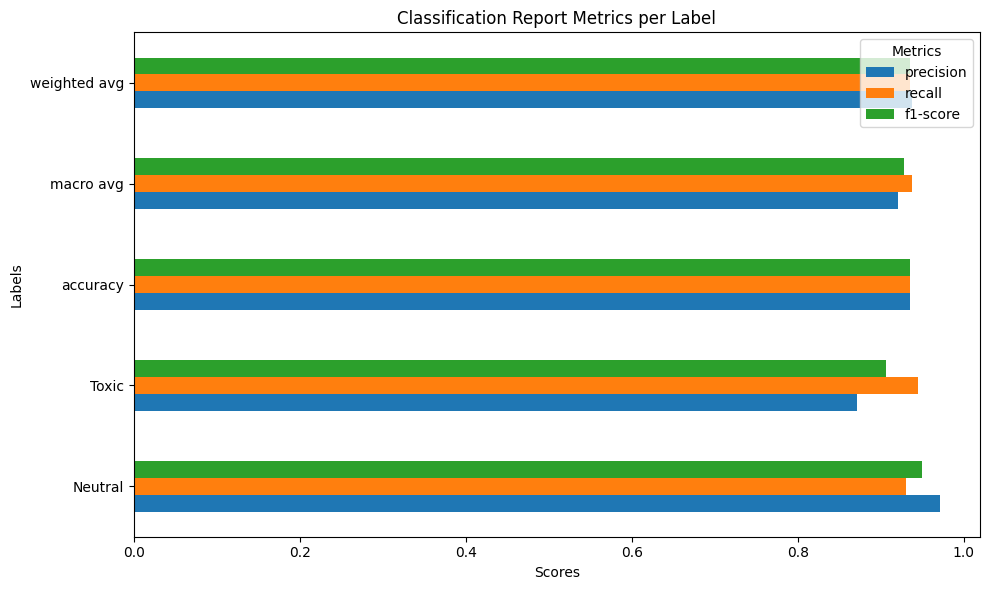

(<Axes: title={'center': 'Classification Report Metrics per Label'}, xlabel='Scores', ylabel='Labels'>,
 [0.081281378865242,
  0.9213488101959229,
  0.937466025352478,
  0.9293375015258789])

In [18]:
plot_classification_report(model, testing_data)

### Model results analysis

In [19]:
# Predict on the test dataset
y_pred_probs = model.predict(testing_data)
y_pred = tf.argmax(y_pred_probs, axis=1)

# Get the true labels
y_true = tf.concat([y for x, y in testing_data], axis=0)
y_true = tf.argmax(y_true, axis=1)

# Find the indices where the predictions are incorrect
incorrect_indices = tf.where(y_pred != y_true)
incorrect_indices = tf.squeeze(incorrect_indices).numpy()

# Find the indices where the predictions are correct
corrected_indices = tf.where(y_pred == y_true)
corrected_indices = tf.squeeze(corrected_indices).numpy()

# Retrieve the corresponding rows from the original dataframe
failed_predictions = data.iloc[incorrect_indices].copy()
correct_predictions = data.iloc[corrected_indices].copy()

# Add predicted probabilities and final predictions as new columns
failed_predictions['predicted_probabilities'] = y_pred_probs[incorrect_indices].tolist()
failed_predictions['final_prediction'] = y_pred.numpy()[incorrect_indices]
correct_predictions['predicted_probabilities'] = y_pred_probs[corrected_indices].tolist()
correct_predictions['final_prediction'] = y_pred.numpy()[corrected_indices]

46/46 [==============================] - 9s 186ms/step


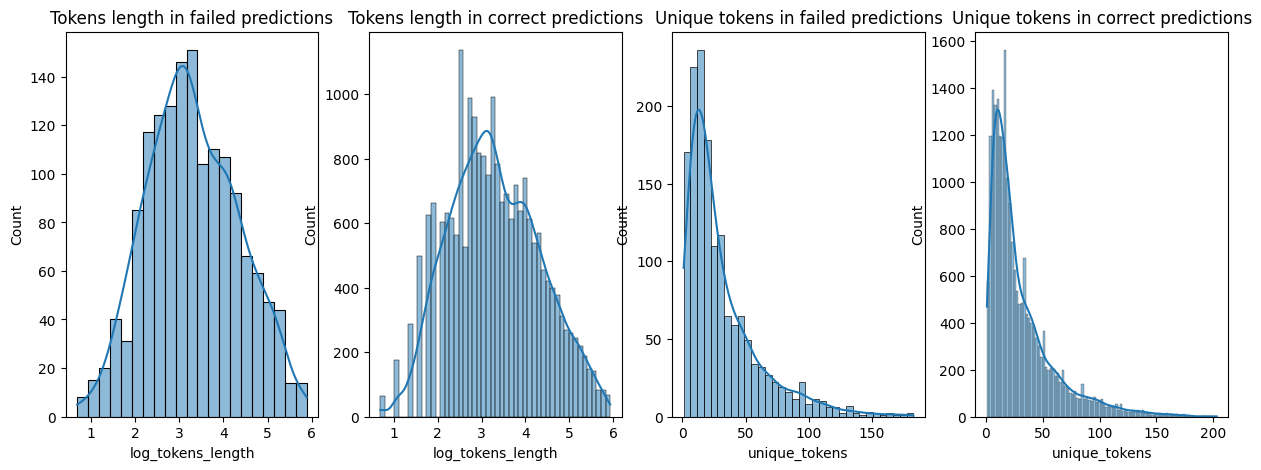

In [35]:
# Plot failed predictions distributions
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

# Distribution of tokens_length in failed predictions
sns.histplot(failed_predictions['log_tokens_length'], kde=True, ax=ax[0])
ax[0].set_title("Tokens length in failed predictions")
# Distribution of tokens_length in correct predictions
sns.histplot(correct_predictions['log_tokens_length'], kde=True, ax=ax[1])
ax[1].set_title("Tokens length in correct predictions")
# Distribution of unique_tokens in failed predictions
sns.histplot(failed_predictions['unique_tokens'], kde=True, ax=ax[2])
ax[2].set_title("Unique tokens in failed predictions")
# Distribution of unique_tokens in correct predictions
sns.histplot(correct_predictions['unique_tokens'], kde=True, ax=ax[3])
ax[3].set_title("Unique tokens in correct predictions")

plt.show();

In [56]:
failed_predictions[failed_predictions.label == failed_predictions.final_prediction].shape

(629, 13)

## Draft baseline Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Params
vocab = list(set([token for token in data['tokens'] for token in token]))
vocab_size = len(vocab)
embedding_dim = 300


# Metrics
metrics = [
      RecallMulticlass(name='recall', n_class=train_dataset.element_spec[1].shape[0]),
      PrecisionMulticlass(name='precision', n_class=train_dataset.element_spec[1].shape[0])
      ]

# Embedding layer
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
    name='embedding'
)

# Model
baseline_model = Sequential([
    embedding_layer,
    LSTM(units=64, name="lstm1"),
    Dense(units=64, activation='relu', name='dense1'),
    Dense(units=3, activation='softmax', name='output')
], name='baseline_model')


baseline_model.compile(optimizer='adam', loss=WeightedCategoricalCrossEntropy(weights=weights),
                       metrics=metrics)

baseline_model.summary()

# train the model
baseline_model_history = baseline_model.fit(batched_dataset, epochs=10, callbacks=[early_stopping, tensorboard_callback],
                                            validation_data=batched_evaluation)

# Evaluate the model
#baseline_model.evaluate(batched_evaluation)

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         8861400   
                                                                 
 lstm1 (LSTM)                (None, 64)                93440     
                                                                 
 dense1 (Dense)              (None, 64)                4160      
                                                                 
 output (Dense)              (None, 3)                 195       
                                                                 
Total params: 8959195 (34.18 MB)
Trainable params: 97795 (382.01 KB)
Non-trainable params: 8861400 (33.80 MB)
_________________________________________________________________
Epoch 1/10
183/183 [==============================] - ETA: 0s - loss: 0.2305 - recall: 0.3320 - precision: 0.3330

/Users/theopinto--dalle/code/arewetoxic/env/lib/python3.10/site-packages/keras/src/engine/training.py:2699: UserWarning: Metric RecallMulticlass implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/Users/theopinto--dalle/code/arewetoxic/env/lib/python3.10/site-packages/keras/src/engine/training.py:2699: UserWarning: Metric PrecisionMulticlass implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


183/183 [==============================] - 26s 130ms/step - loss: 0.2305 - recall: 0.3320 - precision: 0.3330 - val_loss: 0.2300 - val_recall: 0.3338 - val_precision: 0.3883
Epoch 2/10
183/183 [==============================] - 21s 112ms/step - loss: 0.2301 - recall: 0.3329 - precision: 0.3337 - val_loss: 0.2299 - val_recall: 0.3344 - val_precision: 0.3833
Epoch 3/10
183/183 [==============================] - 20s 108ms/step - loss: 0.2303 - recall: 0.3334 - precision: 0.3344 - val_loss: 0.2296 - val_recall: 0.3367 - val_precision: 0.3822
Epoch 4/10
183/183 [==============================] - 20s 107ms/step - loss: 0.2128 - recall: 0.4596 - precision: 0.4434 - val_loss: 0.1837 - val_recall: 0.6016 - val_precision: 0.5744
Epoch 5/10
183/183 [==============================] - 25s 136ms/step - loss: 0.1603 - recall: 0.6681 - precision: 0.6525 - val_loss: 0.1426 - val_recall: 0.7179 - val_precision: 0.7075
Epoch 6/10
183/183 [==============================] - 21s 112ms/step - loss: 0.1494 - 

In [ ]:
# Evaluate the model
eval_results = baseline_model.evaluate(batched_evaluation)
eval_loss, eval_precision, eval_recall = eval_results  # Assuming three metrics
eval_precision, eval_recall

/Users/theopinto--dalle/code/arewetoxic/env/lib/python3.10/site-packages/keras/src/engine/training.py:2699: UserWarning: Metric RecallMulticlass implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/Users/theopinto--dalle/code/arewetoxic/env/lib/python3.10/site-packages/keras/src/engine/training.py:2699: UserWarning: Metric PrecisionMulticlass implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


46/46 [==============================] - 5s 59ms/step - loss: 0.1214 - recall: 0.7647 - precision: 0.7453


(0.7646812796592712, 0.7452775835990906)

In [ ]:
baseline_model.save(os.path.join(project_root, 'models', 'baseline_model'))

INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/saved_models/baseline_model/assets


INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/saved_models/baseline_model/assets


In [ ]:
import mlflow
import mlflow.tensorflow

project_root = os.path.dirname(os.getcwd())
mlruns_path = os.path.join(project_root, 'mlruns')

# Set the tracking URI to the custom path
mlflow.set_tracking_uri(f"file://{mlruns_path}")

## Create or get an existing experiment by name
experiment_name = "baseline_experiment"
#experiment_id = mlflow.create_experiment(experiment_name, artifact_location=f"file://{mlruns_path}")

# Set the experiment
mlflow.set_experiment(experiment_name)


# Start an MLflow run
with mlflow.start_run(run_name="baseline_model") as run:
    # Log model
    mlflow.tensorflow.log_model(baseline_model, "model")
    # Log metrics
    
    for epoch, metrics in enumerate(baseline_model_history.history["loss"]):
        mlflow.log_metric("loss", metrics, step=epoch)
        
    for epoch, metrics in enumerate(baseline_model_history.history["recall"]):
        mlflow.log_metric("recall", metrics, step=epoch)
        
    for epoch, metrics in enumerate(baseline_model_history.history["precision"]):
        mlflow.log_metric("precision", metrics, step=epoch)
    

2024/11/25 19:41:42 INFO mlflow.tracking.fluent: Experiment with name 'baseline_experiment' does not exist. Creating a new experiment.
2024/11/25 19:41:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/60/dhk32zz121zcg97k0qp8m6z40000gn/T/tmp0cp0kct2/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/60/dhk32zz121zcg97k0qp8m6z40000gn/T/tmp0cp0kct2/model/data/model/assets
2024/11/25 19:41:49 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/60/dhk32zz121zcg97k0qp8m6z40000gn/T/tmp0cp0kct2/model, flavor: tensorflow). Fall back to return ['tensorflow==2.14.0', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/25 19:41:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


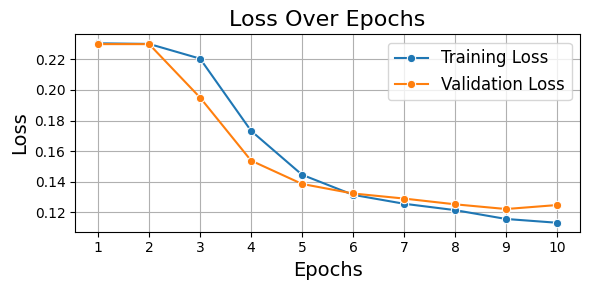

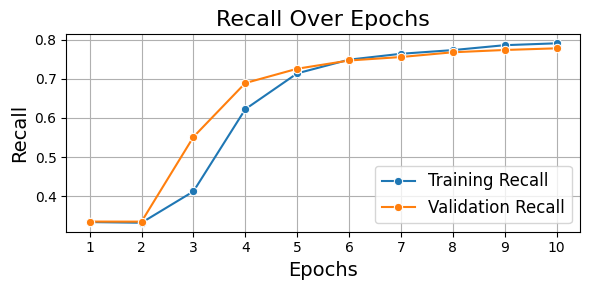

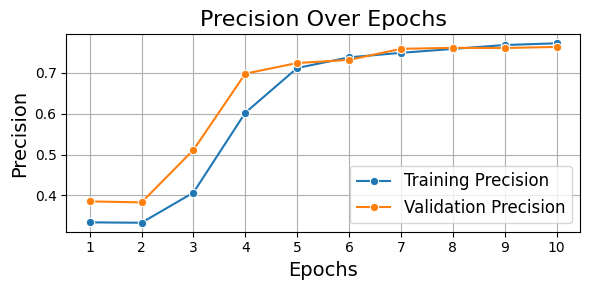

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_metrics_with_seaborn(history):

    # Extract metrics from history
    metrics = [key for key in history.history.keys() if 'val_' not in key]
    epochs = range(1, len(history.history[metrics[0]]) + 1)
    

    for metric in metrics:
        plt.figure(figsize=(6, 3))
        
        # Plot training metric
        sns.lineplot(x=epochs, y=history.history[metric], label=f'Training {metric.capitalize()}', marker='o')
        
        # Plot validation metric if available
        if f'val_{metric}' in history.history:
            sns.lineplot(x=epochs, y=history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}', marker='o')
        
        # Formatting
        plt.title(f'{metric.capitalize()} Over Epochs', fontsize=16)
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel(metric.capitalize(), fontsize=14)
        plt.legend(loc='best', fontsize=12)
        plt.grid(True)
        plt.xticks(epochs)  # Show each epoch number on x-axis
        plt.tight_layout()  # Adjust layout for better fit
        plt.show()

plot_metrics_with_seaborn(baseline_model_history)


# Draft other Model

In [ ]:
import tensorflow as tf

# List all available physical devices
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import tensorflow as tf
import os
project_root = os.path.dirname(os.getcwd())

# Import data
training_data = tf.data.Dataset.load(os.path.join(project_root, 'datasets', 'training', 'training_dataset'))
validation_data = tf.data.Dataset.load(os.path.join(project_root, 'datasets', 'training', 'evaluation_dataset'))

# Load embedding matrix
embedding_matrix = np.load(os.path.join(project_root, 'models', 'embedding_matrix_300.npy'))

In [ ]:
model.save(os.path.join(project_root, 'models', 'bi_lstm_model'))

INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/saved_models/bi_lstm_model/assets


INFO:tensorflow:Assets written to: /Users/theopinto--dalle/code/arewetoxic/saved_models/bi_lstm_model/assets


In [ ]:
results = model.evaluate(validation_data)

46/46 [==============================] - 8s 148ms/step - loss: 0.1862 - recall: 0.7635 - precision: 0.8106


[0.18615120649337769, 0.7634679675102234, 0.810579776763916]

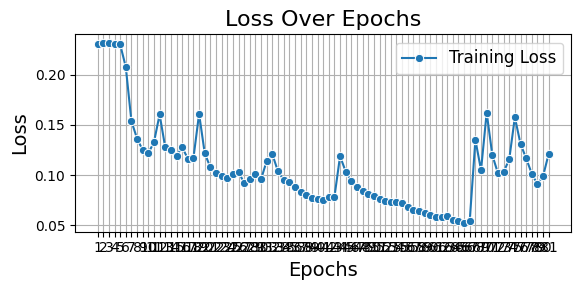

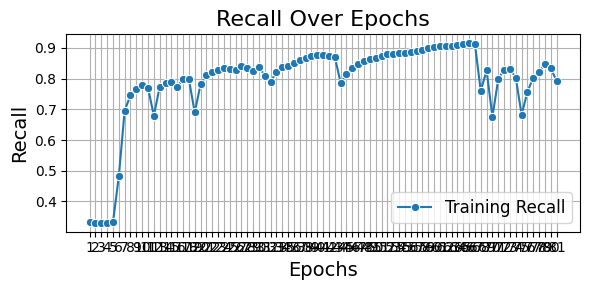

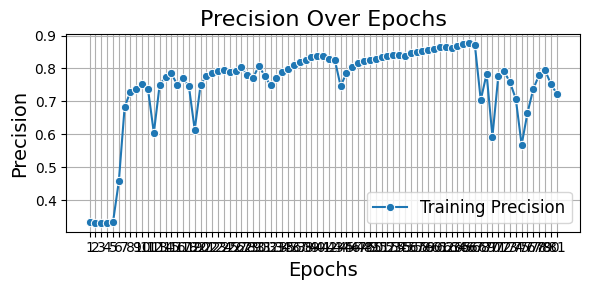

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_metrics_with_seaborn(history):

    # Extract metrics from history
    metrics = [key for key in history.history.keys() if 'val_' not in key]
    epochs = range(1, len(history.history[metrics[0]]) + 1)
    

    for metric in metrics:
        plt.figure(figsize=(6, 3))
        
        # Plot training metric
        sns.lineplot(x=epochs, y=history.history[metric], label=f'Training {metric.capitalize()}', marker='o')
        
        # Plot validation metric if available
        if f'val_{metric}' in history.history:
            sns.lineplot(x=epochs, y=history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}', marker='o')
        
        # Formatting
        plt.title(f'{metric.capitalize()} Over Epochs', fontsize=16)
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel(metric.capitalize(), fontsize=14)
        plt.legend(loc='best', fontsize=12)
        plt.grid(True)
        plt.xticks(epochs)  # Show each epoch number on x-axis
        plt.tight_layout()  # Adjust layout for better fit
        plt.show()

plot_metrics_with_seaborn(history)

In [ ]:
predictions = model.predict(batched_evaluation)

46/46 [==============================] - 11s 128ms/step


array([[0.9906589 , 0.00545689, 0.0038843 ],
       [0.80199754, 0.18904924, 0.00895313],
       [0.00340569, 0.02316417, 0.9734301 ],
       ...,
       [0.99350643, 0.00310729, 0.00338626],
       [0.2828955 , 0.39239874, 0.32470572],
       [0.00670517, 0.9884576 , 0.00483716]], dtype=float32)

In [ ]:
y_pred = tf.argmax(predictions, axis=1)
y_pred.numpy()

array([0, 0, 2, ..., 0, 1, 1])

In [ ]:
y_true = tf.argmax(y_test, axis=1)
y_true.numpy()

array([0, 0, 1, ..., 0, 2, 1])

In [ ]:
# model evaluation
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     15551
           1       0.76      0.77      0.76      4856
           2       0.76      0.57      0.65      2915

    accuracy                           0.87     23322
   macro avg       0.81      0.76      0.78     23322
weighted avg       0.86      0.87      0.86     23322



# MLFlow setup

In [ ]:
data_list = []
for batch in batched_dataset:
    data_list.append(batch[0][0][:].numpy())
    
data_list = np.array(data_list)
input_example = data_list[0]


In [ ]:
# Correct shape for the input example, assuming embeddings are applied inside the model
input_example = np.random.randint(0, 1000, size=(1, 170))
input_example.shape

(1, 170)

In [ ]:
path = os.path.join(project_root, 'datasets', 'training')

batched_dataset.save(os.path.join(path, 'training_dataset'))
batched_evaluation.save(os.path.join(path, 'evaluation_dataset'))

In [ ]:
batched_dataset._batch_size

<tf.Tensor: shape=(), dtype=int64, numpy=512>

In [ ]:
training_dataset = tf.data.Dataset.load(os.path.join(path, 'training_dataset'))

In [ ]:
import tensorflow as tf
import mlflow
import mlflow.tensorflow

project_root = os.path.dirname(os.getcwd())

# Set the experiment name (if it doesn't exist, it will be created)
mlflow.set_experiment("baseline_model_experiment")

# Start an MLflow run
with mlflow.start_run(run_name="baseline_model"):


    # Save a model
    baseline_model_json = baseline_model.to_json()
    with open(os.path.join(project_root, "model_structure.json"), "w") as json_file:
        json_file.write(baseline_model_json)
        mlflow.log_artifact(os.path.join(project_root, "model_structure.json"))  # Save model structure to MLflow
        
    mlflow.tensorflow.save_model(baseline_model, 'baseline_model',
                                 input_example=input_example)

    # Save the model's weights
    baseline_model.save_weights(os.path.join(project_root, "model_weights.h5"))
    mlflow.log_artifact(os.path.join(project_root, "model_weights.h5"))  # Save weights to MLflow

    # Alternatively, you can log the entire model in one go:
    mlflow.tensorflow.log_model(baseline_model, "full_model")
        
    # Save embedding matrix
    mlflow.log_artifact(os.path.join(project_root, 'models', 'embedding_matrix_300.npy'))
        
    # Log evaluation metrics
    mlflow.log_metric("eval_loss", eval_loss)
    mlflow.log_metric("eval_precision", eval_precision)
    mlflow.log_metric("eval_recall", eval_recall)


    # Log parameters
    mlflow.log_param("vocab_size", vocab_size)
    mlflow.log_param("embedding_dim", embedding_dim)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", len(baseline_model_history.history['loss']))
    mlflow.log_param("early_stopping_patience", early_stopping.patience)
    mlflow.log_param("early_stopping_min_delta", early_stopping.min_delta)

    
    mlflow.end_run()

Exception: '/Users/theopinto--dalle/code/arewetoxic/notebooks/mlruns' does not exist.